In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'cg-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Extracting features from ResNet50 layers ...
Saving ResNet50 extracted features into cg-resnet50features.npy ...


In [10]:
resnet50features.shape

(16396, 1, 1, 2048)

In [11]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [12]:
# Training top_model and saving min training loss weights
num_epochs=400
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-resnet50-Adam-400epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/400
14755/14755 [==============================] - 0s - loss: 0.9461 - acc: 0.4666 - val_loss: 0.8460 - val_acc: 0.5545
Epoch 2/400
14755/14755 [==============================] - 0s - loss: 0.8476 - acc: 0.5475 - val_loss: 0.7464 - val_acc: 0.6179
Epoch 3/400
14755/14755 [==============================] - 0s - loss: 0.7462 - acc: 0.6130 - val_loss: 0.6520 - val_acc: 0.6606
Epoch 4/400
14755/14755 [==============================] - 0s - loss: 0.6506 - acc: 0.6617 - val_loss: 0.5860 - val_acc: 0.6977
Epoch 5/400
14755/14755 [==============================] - 0s - loss: 0.5843 - acc: 0.6961 - val_loss: 0.5353 - val_acc: 0.7380
Epoch 6/400
14755/14755 [==============================] - 0s - loss: 0.5331 - acc: 0.7306 - val_loss: 0.4890 - val_acc: 0.7678
Epoch 7/400
14755/14755 [==============================] - 0s - loss: 0.4860 - acc: 0.7645 - val_loss: 0.4524 - val_acc: 0.7879
Epoch 8/400
14755/14755 [==============================

14755/14755 [==============================] - 0s - loss: 0.1609 - acc: 0.9398 - val_loss: 0.1781 - val_acc: 0.9317
Epoch 65/400
14755/14755 [==============================] - 0s - loss: 0.1599 - acc: 0.9401 - val_loss: 0.1774 - val_acc: 0.9324
Epoch 66/400
14755/14755 [==============================] - 0s - loss: 0.1589 - acc: 0.9404 - val_loss: 0.1767 - val_acc: 0.9324
Epoch 67/400
14755/14755 [==============================] - 0s - loss: 0.1580 - acc: 0.9407 - val_loss: 0.1760 - val_acc: 0.9324
Epoch 68/400
14755/14755 [==============================] - 0s - loss: 0.1570 - acc: 0.9416 - val_loss: 0.1754 - val_acc: 0.9311
Epoch 69/400
14755/14755 [==============================] - 0s - loss: 0.1561 - acc: 0.9422 - val_loss: 0.1748 - val_acc: 0.9305
Epoch 70/400
14755/14755 [==============================] - 0s - loss: 0.1552 - acc: 0.9425 - val_loss: 0.1742 - val_acc: 0.9305
Epoch 71/400
14755/14755 [==============================] - 0s - loss: 0.1543 - acc: 0.9429 - val_loss: 0.1735

14755/14755 [==============================] - 0s - loss: 0.1213 - acc: 0.9566 - val_loss: 0.1517 - val_acc: 0.9403
Epoch 128/400
14755/14755 [==============================] - 0s - loss: 0.1209 - acc: 0.9568 - val_loss: 0.1515 - val_acc: 0.9403
Epoch 129/400
14755/14755 [==============================] - 0s - loss: 0.1205 - acc: 0.9571 - val_loss: 0.1512 - val_acc: 0.9403
Epoch 130/400
14755/14755 [==============================] - 0s - loss: 0.1201 - acc: 0.9572 - val_loss: 0.1510 - val_acc: 0.9403
Epoch 131/400
14755/14755 [==============================] - 0s - loss: 0.1197 - acc: 0.9573 - val_loss: 0.1508 - val_acc: 0.9403
Epoch 132/400
14755/14755 [==============================] - 0s - loss: 0.1193 - acc: 0.9576 - val_loss: 0.1505 - val_acc: 0.9403
Epoch 133/400
14755/14755 [==============================] - 0s - loss: 0.1189 - acc: 0.9576 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 134/400
14755/14755 [==============================] - 0s - loss: 0.1185 - acc: 0.9577 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.1015 - acc: 0.9663 - val_loss: 0.1413 - val_acc: 0.9433
Epoch 191/400
14755/14755 [==============================] - 0s - loss: 0.1012 - acc: 0.9665 - val_loss: 0.1412 - val_acc: 0.9433
Epoch 192/400
14755/14755 [==============================] - 0s - loss: 0.1010 - acc: 0.9665 - val_loss: 0.1411 - val_acc: 0.9433
Epoch 193/400
14755/14755 [==============================] - 0s - loss: 0.1008 - acc: 0.9666 - val_loss: 0.1409 - val_acc: 0.9433
Epoch 194/400
14755/14755 [==============================] - 0s - loss: 0.1005 - acc: 0.9667 - val_loss: 0.1408 - val_acc: 0.9433
Epoch 195/400
14755/14755 [==============================] - 0s - loss: 0.1003 - acc: 0.9667 - val_loss: 0.1407 - val_acc: 0.9439
Epoch 196/400
14755/14755 [==============================] - 0s - loss: 0.1000 - acc: 0.9668 - val_loss: 0.1406 - val_acc: 0.9439
Epoch 197/400
14755/14755 [==============================] - 0s - loss: 0.0998 - acc: 0.9667 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0887 - acc: 0.9710 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 254/400
14755/14755 [==============================] - 0s - loss: 0.0886 - acc: 0.9710 - val_loss: 0.1363 - val_acc: 0.9458
Epoch 255/400
14755/14755 [==============================] - 0s - loss: 0.0884 - acc: 0.9714 - val_loss: 0.1363 - val_acc: 0.9458
Epoch 256/400
14755/14755 [==============================] - 0s - loss: 0.0882 - acc: 0.9714 - val_loss: 0.1362 - val_acc: 0.9458
Epoch 257/400
14755/14755 [==============================] - 0s - loss: 0.0881 - acc: 0.9715 - val_loss: 0.1362 - val_acc: 0.9458
Epoch 258/400
14755/14755 [==============================] - 0s - loss: 0.0879 - acc: 0.9715 - val_loss: 0.1361 - val_acc: 0.9458
Epoch 259/400
14755/14755 [==============================] - 0s - loss: 0.0877 - acc: 0.9715 - val_loss: 0.1361 - val_acc: 0.9458
Epoch 260/400
14755/14755 [==============================] - 0s - loss: 0.0876 - acc: 0.9715 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0796 - acc: 0.9742 - val_loss: 0.1340 - val_acc: 0.9512
Epoch 317/400
14755/14755 [==============================] - 0s - loss: 0.0794 - acc: 0.9742 - val_loss: 0.1340 - val_acc: 0.9519
Epoch 318/400
14755/14755 [==============================] - 0s - loss: 0.0793 - acc: 0.9742 - val_loss: 0.1340 - val_acc: 0.9519
Epoch 319/400
14755/14755 [==============================] - 0s - loss: 0.0792 - acc: 0.9742 - val_loss: 0.1340 - val_acc: 0.9519
Epoch 320/400
14755/14755 [==============================] - 0s - loss: 0.0791 - acc: 0.9743 - val_loss: 0.1339 - val_acc: 0.9519
Epoch 321/400
14755/14755 [==============================] - 0s - loss: 0.0789 - acc: 0.9743 - val_loss: 0.1339 - val_acc: 0.9519
Epoch 322/400
14755/14755 [==============================] - 0s - loss: 0.0788 - acc: 0.9744 - val_loss: 0.1339 - val_acc: 0.9519
Epoch 323/400
14755/14755 [==============================] - 0s - loss: 0.0787 - acc: 0.9745 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0725 - acc: 0.9770 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 380/400
14755/14755 [==============================] - 0s - loss: 0.0724 - acc: 0.9770 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 381/400
14755/14755 [==============================] - 0s - loss: 0.0723 - acc: 0.9771 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 382/400
14755/14755 [==============================] - 0s - loss: 0.0722 - acc: 0.9772 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 383/400
14755/14755 [==============================] - 0s - loss: 0.0721 - acc: 0.9772 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 384/400
14755/14755 [==============================] - 0s - loss: 0.0720 - acc: 0.9774 - val_loss: 0.1331 - val_acc: 0.9537
Epoch 385/400
14755/14755 [==============================] - 0s - loss: 0.0719 - acc: 0.9774 - val_loss: 0.1331 - val_acc: 0.9531
Epoch 386/400
14755/14755 [==============================] - 0s - loss: 0.0718 - acc: 0.9774 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.2041 - acc: 0.9160 - val_loss: 0.1870 - val_acc: 0.9244
Epoch 42/400
14755/14755 [==============================] - 0s - loss: 0.2019 - acc: 0.9167 - val_loss: 0.1849 - val_acc: 0.9250
Epoch 43/400
14755/14755 [==============================] - 0s - loss: 0.2000 - acc: 0.9176 - val_loss: 0.1830 - val_acc: 0.9257
Epoch 44/400
14755/14755 [==============================] - 0s - loss: 0.1981 - acc: 0.9188 - val_loss: 0.1811 - val_acc: 0.9275
Epoch 45/400
14755/14755 [==============================] - 0s - loss: 0.1962 - acc: 0.9200 - val_loss: 0.1792 - val_acc: 0.9287
Epoch 46/400
14755/14755 [==============================] - 0s - loss: 0.1943 - acc: 0.9209 - val_loss: 0.1775 - val_acc: 0.9299
Epoch 47/400
14755/14755 [==============================] - 0s - loss: 0.1925 - acc: 0.9220 - val_loss: 0.1758 - val_acc: 0.9317
Epoch 48/400
14755/14755 [==============================] - 0s - loss: 0.1908 - acc: 0.9231 - val_loss: 0.1743

14755/14755 [==============================] - 0s - loss: 0.1389 - acc: 0.9482 - val_loss: 0.1308 - val_acc: 0.9561
Epoch 105/400
14755/14755 [==============================] - 0s - loss: 0.1384 - acc: 0.9484 - val_loss: 0.1304 - val_acc: 0.9561
Epoch 106/400
14755/14755 [==============================] - 0s - loss: 0.1379 - acc: 0.9487 - val_loss: 0.1300 - val_acc: 0.9561
Epoch 107/400
14755/14755 [==============================] - 0s - loss: 0.1373 - acc: 0.9490 - val_loss: 0.1296 - val_acc: 0.9561
Epoch 108/400
14755/14755 [==============================] - 0s - loss: 0.1368 - acc: 0.9493 - val_loss: 0.1292 - val_acc: 0.9561
Epoch 109/400
14755/14755 [==============================] - 0s - loss: 0.1363 - acc: 0.9494 - val_loss: 0.1289 - val_acc: 0.9555
Epoch 110/400
14755/14755 [==============================] - 0s - loss: 0.1358 - acc: 0.9498 - val_loss: 0.1285 - val_acc: 0.9549
Epoch 111/400
14755/14755 [==============================] - 0s - loss: 0.1353 - acc: 0.9501 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.1142 - acc: 0.9589 - val_loss: 0.1147 - val_acc: 0.9586
Epoch 168/400
14755/14755 [==============================] - 0s - loss: 0.1139 - acc: 0.9590 - val_loss: 0.1145 - val_acc: 0.9586
Epoch 169/400
14755/14755 [==============================] - 0s - loss: 0.1136 - acc: 0.9591 - val_loss: 0.1143 - val_acc: 0.9586
Epoch 170/400
14755/14755 [==============================] - 0s - loss: 0.1133 - acc: 0.9591 - val_loss: 0.1142 - val_acc: 0.9586
Epoch 171/400
14755/14755 [==============================] - 0s - loss: 0.1131 - acc: 0.9593 - val_loss: 0.1140 - val_acc: 0.9586
Epoch 172/400
14755/14755 [==============================] - 0s - loss: 0.1128 - acc: 0.9593 - val_loss: 0.1139 - val_acc: 0.9586
Epoch 173/400
14755/14755 [==============================] - 0s - loss: 0.1125 - acc: 0.9594 - val_loss: 0.1137 - val_acc: 0.9586
Epoch 174/400
14755/14755 [==============================] - 0s - loss: 0.1122 - acc: 0.9594 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0994 - acc: 0.9652 - val_loss: 0.1070 - val_acc: 0.9616
Epoch 231/400
14755/14755 [==============================] - 0s - loss: 0.0992 - acc: 0.9652 - val_loss: 0.1069 - val_acc: 0.9616
Epoch 232/400
14755/14755 [==============================] - 0s - loss: 0.0990 - acc: 0.9653 - val_loss: 0.1068 - val_acc: 0.9616
Epoch 233/400
14755/14755 [==============================] - 0s - loss: 0.0988 - acc: 0.9654 - val_loss: 0.1067 - val_acc: 0.9616
Epoch 234/400
14755/14755 [==============================] - 0s - loss: 0.0986 - acc: 0.9654 - val_loss: 0.1066 - val_acc: 0.9622
Epoch 235/400
14755/14755 [==============================] - 0s - loss: 0.0984 - acc: 0.9654 - val_loss: 0.1066 - val_acc: 0.9622
Epoch 236/400
14755/14755 [==============================] - 0s - loss: 0.0982 - acc: 0.9654 - val_loss: 0.1065 - val_acc: 0.9622
Epoch 237/400
14755/14755 [==============================] - 0s - loss: 0.0980 - acc: 0.9654 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0890 - acc: 0.9691 - val_loss: 0.1026 - val_acc: 0.9622
Epoch 294/400
14755/14755 [==============================] - 0s - loss: 0.0889 - acc: 0.9692 - val_loss: 0.1026 - val_acc: 0.9622
Epoch 295/400
14755/14755 [==============================] - 0s - loss: 0.0887 - acc: 0.9693 - val_loss: 0.1025 - val_acc: 0.9622
Epoch 296/400
14755/14755 [==============================] - 0s - loss: 0.0886 - acc: 0.9693 - val_loss: 0.1025 - val_acc: 0.9616
Epoch 297/400
14755/14755 [==============================] - 0s - loss: 0.0884 - acc: 0.9693 - val_loss: 0.1024 - val_acc: 0.9616
Epoch 298/400
14755/14755 [==============================] - 0s - loss: 0.0883 - acc: 0.9695 - val_loss: 0.1024 - val_acc: 0.9616
Epoch 299/400
14755/14755 [==============================] - 0s - loss: 0.0882 - acc: 0.9696 - val_loss: 0.1023 - val_acc: 0.9616
Epoch 300/400
14755/14755 [==============================] - 0s - loss: 0.0880 - acc: 0.9696 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.0812 - acc: 0.9728 - val_loss: 0.1000 - val_acc: 0.9628
Epoch 357/400
14755/14755 [==============================] - 0s - loss: 0.0811 - acc: 0.9728 - val_loss: 0.0999 - val_acc: 0.9628
Epoch 358/400
14755/14755 [==============================] - 0s - loss: 0.0809 - acc: 0.9728 - val_loss: 0.0999 - val_acc: 0.9628
Epoch 359/400
14755/14755 [==============================] - 0s - loss: 0.0808 - acc: 0.9728 - val_loss: 0.0999 - val_acc: 0.9628
Epoch 360/400
14755/14755 [==============================] - 0s - loss: 0.0807 - acc: 0.9729 - val_loss: 0.0998 - val_acc: 0.9628
Epoch 361/400
14755/14755 [==============================] - 0s - loss: 0.0806 - acc: 0.9730 - val_loss: 0.0998 - val_acc: 0.9628
Epoch 362/400
14755/14755 [==============================] - 0s - loss: 0.0805 - acc: 0.9731 - val_loss: 0.0998 - val_acc: 0.9634
Epoch 363/400
14755/14755 [==============================] - 0s - loss: 0.0804 - acc: 0.9732 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.3272 - acc: 0.8573 - val_loss: 0.3002 - val_acc: 0.8665
Epoch 19/400
14756/14756 [==============================] - 0s - loss: 0.3188 - acc: 0.8617 - val_loss: 0.2932 - val_acc: 0.8713
Epoch 20/400
14756/14756 [==============================] - 0s - loss: 0.3102 - acc: 0.8654 - val_loss: 0.2877 - val_acc: 0.8732
Epoch 21/400
14756/14756 [==============================] - 0s - loss: 0.3028 - acc: 0.8681 - val_loss: 0.2835 - val_acc: 0.8756
Epoch 22/400
14756/14756 [==============================] - 0s - loss: 0.2968 - acc: 0.8707 - val_loss: 0.2800 - val_acc: 0.8762
Epoch 23/400
14756/14756 [==============================] - 0s - loss: 0.2918 - acc: 0.8733 - val_loss: 0.2760 - val_acc: 0.8768
Epoch 24/400
14756/14756 [==============================] - 0s - loss: 0.2867 - acc: 0.8750 - val_loss: 0.2712 - val_acc: 0.8756
Epoch 25/400
14756/14756 [==============================] - 0s - loss: 0.2811 - acc: 0.8775 - val_loss: 0.2657

14756/14756 [==============================] - 0s - loss: 0.1660 - acc: 0.9367 - val_loss: 0.1689 - val_acc: 0.9323
Epoch 82/400
14756/14756 [==============================] - 0s - loss: 0.1652 - acc: 0.9372 - val_loss: 0.1682 - val_acc: 0.9329
Epoch 83/400
14756/14756 [==============================] - 0s - loss: 0.1644 - acc: 0.9375 - val_loss: 0.1676 - val_acc: 0.9329
Epoch 84/400
14756/14756 [==============================] - 0s - loss: 0.1636 - acc: 0.9382 - val_loss: 0.1670 - val_acc: 0.9329
Epoch 85/400
14756/14756 [==============================] - 0s - loss: 0.1629 - acc: 0.9383 - val_loss: 0.1664 - val_acc: 0.9335
Epoch 86/400
14756/14756 [==============================] - 0s - loss: 0.1621 - acc: 0.9390 - val_loss: 0.1658 - val_acc: 0.9341
Epoch 87/400
14756/14756 [==============================] - 0s - loss: 0.1614 - acc: 0.9391 - val_loss: 0.1652 - val_acc: 0.9348
Epoch 88/400
14756/14756 [==============================] - 0s - loss: 0.1607 - acc: 0.9393 - val_loss: 0.1646

14756/14756 [==============================] - 0s - loss: 0.1318 - acc: 0.9526 - val_loss: 0.1419 - val_acc: 0.9463
Epoch 145/400
14756/14756 [==============================] - 0s - loss: 0.1314 - acc: 0.9526 - val_loss: 0.1416 - val_acc: 0.9463
Epoch 146/400
14756/14756 [==============================] - 0s - loss: 0.1310 - acc: 0.9529 - val_loss: 0.1413 - val_acc: 0.9463
Epoch 147/400
14756/14756 [==============================] - 0s - loss: 0.1306 - acc: 0.9529 - val_loss: 0.1410 - val_acc: 0.9463
Epoch 148/400
14756/14756 [==============================] - 0s - loss: 0.1303 - acc: 0.9530 - val_loss: 0.1407 - val_acc: 0.9463
Epoch 149/400
14756/14756 [==============================] - 0s - loss: 0.1299 - acc: 0.9532 - val_loss: 0.1405 - val_acc: 0.9470
Epoch 150/400
14756/14756 [==============================] - 0s - loss: 0.1296 - acc: 0.9532 - val_loss: 0.1402 - val_acc: 0.9470
Epoch 151/400
14756/14756 [==============================] - 0s - loss: 0.1292 - acc: 0.9533 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1129 - acc: 0.9608 - val_loss: 0.1283 - val_acc: 0.9537
Epoch 208/400
14756/14756 [==============================] - 0s - loss: 0.1126 - acc: 0.9609 - val_loss: 0.1281 - val_acc: 0.9537
Epoch 209/400
14756/14756 [==============================] - 0s - loss: 0.1124 - acc: 0.9610 - val_loss: 0.1279 - val_acc: 0.9537
Epoch 210/400
14756/14756 [==============================] - 0s - loss: 0.1121 - acc: 0.9611 - val_loss: 0.1278 - val_acc: 0.9537
Epoch 211/400
14756/14756 [==============================] - 0s - loss: 0.1119 - acc: 0.9611 - val_loss: 0.1276 - val_acc: 0.9537
Epoch 212/400
14756/14756 [==============================] - 0s - loss: 0.1117 - acc: 0.9612 - val_loss: 0.1275 - val_acc: 0.9537
Epoch 213/400
14756/14756 [==============================] - 0s - loss: 0.1114 - acc: 0.9610 - val_loss: 0.1273 - val_acc: 0.9537
Epoch 214/400
14756/14756 [==============================] - 0s - loss: 0.1112 - acc: 0.9610 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1001 - acc: 0.9654 - val_loss: 0.1203 - val_acc: 0.9561
Epoch 271/400
14756/14756 [==============================] - 0s - loss: 0.1000 - acc: 0.9655 - val_loss: 0.1202 - val_acc: 0.9561
Epoch 272/400
14756/14756 [==============================] - 0s - loss: 0.0998 - acc: 0.9656 - val_loss: 0.1201 - val_acc: 0.9561
Epoch 273/400
14756/14756 [==============================] - 0s - loss: 0.0996 - acc: 0.9656 - val_loss: 0.1200 - val_acc: 0.9561
Epoch 274/400
14756/14756 [==============================] - 0s - loss: 0.0995 - acc: 0.9658 - val_loss: 0.1199 - val_acc: 0.9561
Epoch 275/400
14756/14756 [==============================] - 0s - loss: 0.0993 - acc: 0.9658 - val_loss: 0.1198 - val_acc: 0.9561
Epoch 276/400
14756/14756 [==============================] - 0s - loss: 0.0991 - acc: 0.9658 - val_loss: 0.1197 - val_acc: 0.9561
Epoch 277/400
14756/14756 [==============================] - 0s - loss: 0.0990 - acc: 0.9658 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.0907 - acc: 0.9704 - val_loss: 0.1152 - val_acc: 0.9555
Epoch 334/400
14756/14756 [==============================] - 0s - loss: 0.0906 - acc: 0.9705 - val_loss: 0.1152 - val_acc: 0.9555
Epoch 335/400
14756/14756 [==============================] - 0s - loss: 0.0905 - acc: 0.9705 - val_loss: 0.1151 - val_acc: 0.9555
Epoch 336/400
14756/14756 [==============================] - 0s - loss: 0.0904 - acc: 0.9705 - val_loss: 0.1151 - val_acc: 0.9555
Epoch 337/400
14756/14756 [==============================] - 0s - loss: 0.0902 - acc: 0.9705 - val_loss: 0.1150 - val_acc: 0.9555
Epoch 338/400
14756/14756 [==============================] - 0s - loss: 0.0901 - acc: 0.9705 - val_loss: 0.1149 - val_acc: 0.9555
Epoch 339/400
14756/14756 [==============================] - 0s - loss: 0.0900 - acc: 0.9706 - val_loss: 0.1149 - val_acc: 0.9549
Epoch 340/400
14756/14756 [==============================] - 0s - loss: 0.0898 - acc: 0.9706 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.0834 - acc: 0.9723 - val_loss: 0.1121 - val_acc: 0.9549
Epoch 397/400
14756/14756 [==============================] - 0s - loss: 0.0833 - acc: 0.9724 - val_loss: 0.1120 - val_acc: 0.9549
Epoch 398/400
14756/14756 [==============================] - 0s - loss: 0.0832 - acc: 0.9724 - val_loss: 0.1120 - val_acc: 0.9543
Epoch 399/400
14756/14756 [==============================] - 0s - loss: 0.0831 - acc: 0.9726 - val_loss: 0.1119 - val_acc: 0.9543
Epoch 400/400
14756/14756 [==============================] - 0s - loss: 0.0830 - acc: 0.9727 - val_loss: 0.1119 - val_acc: 0.9543
[2] Test acurracy: 0.9543
Train on 14756 samples, validate on 1640 samples
Epoch 1/400
14756/14756 [==============================] - 0s - loss: 0.8362 - acc: 0.5571 - val_loss: 0.7619 - val_acc: 0.5762
Epoch 2/400
14756/14756 [==============================] - 0s - loss: 0.7714 - acc: 0.5545 - val_loss: 0.6757 - val_acc: 0.6390
Epoch 3/400
14756/14756 [========

14756/14756 [==============================] - 0s - loss: 0.1758 - acc: 0.9328 - val_loss: 0.1814 - val_acc: 0.9329
Epoch 60/400
14756/14756 [==============================] - 0s - loss: 0.1746 - acc: 0.9332 - val_loss: 0.1802 - val_acc: 0.9329
Epoch 61/400
14756/14756 [==============================] - 0s - loss: 0.1734 - acc: 0.9339 - val_loss: 0.1792 - val_acc: 0.9329
Epoch 62/400
14756/14756 [==============================] - 0s - loss: 0.1723 - acc: 0.9347 - val_loss: 0.1781 - val_acc: 0.9329
Epoch 63/400
14756/14756 [==============================] - 0s - loss: 0.1712 - acc: 0.9352 - val_loss: 0.1771 - val_acc: 0.9335
Epoch 64/400
14756/14756 [==============================] - 0s - loss: 0.1702 - acc: 0.9355 - val_loss: 0.1762 - val_acc: 0.9341
Epoch 65/400
14756/14756 [==============================] - 0s - loss: 0.1691 - acc: 0.9358 - val_loss: 0.1753 - val_acc: 0.9360
Epoch 66/400
14756/14756 [==============================] - 0s - loss: 0.1681 - acc: 0.9362 - val_loss: 0.1744

14756/14756 [==============================] - 0s - loss: 0.1323 - acc: 0.9517 - val_loss: 0.1457 - val_acc: 0.9457
Epoch 123/400
14756/14756 [==============================] - 0s - loss: 0.1319 - acc: 0.9518 - val_loss: 0.1454 - val_acc: 0.9457
Epoch 124/400
14756/14756 [==============================] - 0s - loss: 0.1314 - acc: 0.9522 - val_loss: 0.1451 - val_acc: 0.9457
Epoch 125/400
14756/14756 [==============================] - 0s - loss: 0.1310 - acc: 0.9524 - val_loss: 0.1448 - val_acc: 0.9457
Epoch 126/400
14756/14756 [==============================] - 0s - loss: 0.1306 - acc: 0.9526 - val_loss: 0.1445 - val_acc: 0.9457
Epoch 127/400
14756/14756 [==============================] - 0s - loss: 0.1302 - acc: 0.9527 - val_loss: 0.1442 - val_acc: 0.9457
Epoch 128/400
14756/14756 [==============================] - 0s - loss: 0.1298 - acc: 0.9528 - val_loss: 0.1439 - val_acc: 0.9457
Epoch 129/400
14756/14756 [==============================] - 0s - loss: 0.1294 - acc: 0.9531 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1115 - acc: 0.9601 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 186/400
14756/14756 [==============================] - 0s - loss: 0.1112 - acc: 0.9602 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 187/400
14756/14756 [==============================] - 0s - loss: 0.1110 - acc: 0.9604 - val_loss: 0.1311 - val_acc: 0.9500
Epoch 188/400
14756/14756 [==============================] - 0s - loss: 0.1107 - acc: 0.9609 - val_loss: 0.1310 - val_acc: 0.9500
Epoch 189/400
14756/14756 [==============================] - 0s - loss: 0.1105 - acc: 0.9610 - val_loss: 0.1308 - val_acc: 0.9500
Epoch 190/400
14756/14756 [==============================] - 0s - loss: 0.1102 - acc: 0.9611 - val_loss: 0.1307 - val_acc: 0.9500
Epoch 191/400
14756/14756 [==============================] - 0s - loss: 0.1100 - acc: 0.9613 - val_loss: 0.1305 - val_acc: 0.9506
Epoch 192/400
14756/14756 [==============================] - 0s - loss: 0.1097 - acc: 0.9614 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.0981 - acc: 0.9666 - val_loss: 0.1235 - val_acc: 0.9537
Epoch 249/400
14756/14756 [==============================] - 0s - loss: 0.0979 - acc: 0.9666 - val_loss: 0.1234 - val_acc: 0.9537
Epoch 250/400
14756/14756 [==============================] - 0s - loss: 0.0977 - acc: 0.9666 - val_loss: 0.1233 - val_acc: 0.9537
Epoch 251/400
14756/14756 [==============================] - 0s - loss: 0.0975 - acc: 0.9669 - val_loss: 0.1232 - val_acc: 0.9537
Epoch 252/400
14756/14756 [==============================] - 0s - loss: 0.0974 - acc: 0.9669 - val_loss: 0.1231 - val_acc: 0.9537
Epoch 253/400
14756/14756 [==============================] - 0s - loss: 0.0972 - acc: 0.9669 - val_loss: 0.1230 - val_acc: 0.9537
Epoch 254/400
14756/14756 [==============================] - 0s - loss: 0.0970 - acc: 0.9669 - val_loss: 0.1229 - val_acc: 0.9537
Epoch 255/400
14756/14756 [==============================] - 0s - loss: 0.0968 - acc: 0.9671 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.0883 - acc: 0.9695 - val_loss: 0.1186 - val_acc: 0.9561
Epoch 312/400
14756/14756 [==============================] - 0s - loss: 0.0882 - acc: 0.9695 - val_loss: 0.1185 - val_acc: 0.9561
Epoch 313/400
14756/14756 [==============================] - 0s - loss: 0.0881 - acc: 0.9695 - val_loss: 0.1185 - val_acc: 0.9561
Epoch 314/400
14756/14756 [==============================] - 0s - loss: 0.0879 - acc: 0.9696 - val_loss: 0.1184 - val_acc: 0.9561
Epoch 315/400
14756/14756 [==============================] - 0s - loss: 0.0878 - acc: 0.9696 - val_loss: 0.1183 - val_acc: 0.9561
Epoch 316/400
14756/14756 [==============================] - 0s - loss: 0.0877 - acc: 0.9698 - val_loss: 0.1183 - val_acc: 0.9561
Epoch 317/400
14756/14756 [==============================] - 0s - loss: 0.0876 - acc: 0.9698 - val_loss: 0.1182 - val_acc: 0.9561
Epoch 318/400
14756/14756 [==============================] - 0s - loss: 0.0874 - acc: 0.9699 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.0808 - acc: 0.9730 - val_loss: 0.1154 - val_acc: 0.9579
Epoch 375/400
14756/14756 [==============================] - 0s - loss: 0.0807 - acc: 0.9730 - val_loss: 0.1154 - val_acc: 0.9579
Epoch 376/400
14756/14756 [==============================] - 0s - loss: 0.0806 - acc: 0.9730 - val_loss: 0.1153 - val_acc: 0.9579
Epoch 377/400
14756/14756 [==============================] - 0s - loss: 0.0805 - acc: 0.9730 - val_loss: 0.1153 - val_acc: 0.9579
Epoch 378/400
14756/14756 [==============================] - 0s - loss: 0.0804 - acc: 0.9731 - val_loss: 0.1152 - val_acc: 0.9579
Epoch 379/400
14756/14756 [==============================] - 0s - loss: 0.0803 - acc: 0.9731 - val_loss: 0.1152 - val_acc: 0.9579
Epoch 380/400
14756/14756 [==============================] - 0s - loss: 0.0802 - acc: 0.9731 - val_loss: 0.1152 - val_acc: 0.9579
Epoch 381/400
14756/14756 [==============================] - 0s - loss: 0.0801 - acc: 0.9731 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.2267 - acc: 0.9090 - val_loss: 0.2160 - val_acc: 0.9170
Epoch 37/400
14757/14757 [==============================] - 0s - loss: 0.2236 - acc: 0.9098 - val_loss: 0.2135 - val_acc: 0.9182
Epoch 38/400
14757/14757 [==============================] - 0s - loss: 0.2207 - acc: 0.9111 - val_loss: 0.2112 - val_acc: 0.9195
Epoch 39/400
14757/14757 [==============================] - 0s - loss: 0.2182 - acc: 0.9122 - val_loss: 0.2092 - val_acc: 0.9201
Epoch 40/400
14757/14757 [==============================] - 0s - loss: 0.2159 - acc: 0.9137 - val_loss: 0.2074 - val_acc: 0.9213
Epoch 41/400
14757/14757 [==============================] - 0s - loss: 0.2136 - acc: 0.9150 - val_loss: 0.2057 - val_acc: 0.9213
Epoch 42/400
14757/14757 [==============================] - 0s - loss: 0.2113 - acc: 0.9161 - val_loss: 0.2040 - val_acc: 0.9237
Epoch 43/400
14757/14757 [==============================] - 0s - loss: 0.2090 - acc: 0.9170 - val_loss: 0.2026

14757/14757 [==============================] - 0s - loss: 0.1491 - acc: 0.9432 - val_loss: 0.1607 - val_acc: 0.9384
Epoch 100/400
14757/14757 [==============================] - 0s - loss: 0.1485 - acc: 0.9436 - val_loss: 0.1603 - val_acc: 0.9390
Epoch 101/400
14757/14757 [==============================] - 0s - loss: 0.1480 - acc: 0.9438 - val_loss: 0.1600 - val_acc: 0.9390
Epoch 102/400
14757/14757 [==============================] - 0s - loss: 0.1474 - acc: 0.9441 - val_loss: 0.1596 - val_acc: 0.9390
Epoch 103/400
14757/14757 [==============================] - 0s - loss: 0.1468 - acc: 0.9444 - val_loss: 0.1593 - val_acc: 0.9390
Epoch 104/400
14757/14757 [==============================] - 0s - loss: 0.1462 - acc: 0.9445 - val_loss: 0.1590 - val_acc: 0.9390
Epoch 105/400
14757/14757 [==============================] - 0s - loss: 0.1457 - acc: 0.9448 - val_loss: 0.1586 - val_acc: 0.9390
Epoch 106/400
14757/14757 [==============================] - 0s - loss: 0.1451 - acc: 0.9452 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1218 - acc: 0.9555 - val_loss: 0.1453 - val_acc: 0.9463
Epoch 163/400
14757/14757 [==============================] - 0s - loss: 0.1214 - acc: 0.9556 - val_loss: 0.1451 - val_acc: 0.9463
Epoch 164/400
14757/14757 [==============================] - 0s - loss: 0.1211 - acc: 0.9557 - val_loss: 0.1449 - val_acc: 0.9463
Epoch 165/400
14757/14757 [==============================] - 0s - loss: 0.1208 - acc: 0.9558 - val_loss: 0.1448 - val_acc: 0.9463
Epoch 166/400
14757/14757 [==============================] - 0s - loss: 0.1205 - acc: 0.9560 - val_loss: 0.1446 - val_acc: 0.9469
Epoch 167/400
14757/14757 [==============================] - 0s - loss: 0.1202 - acc: 0.9560 - val_loss: 0.1444 - val_acc: 0.9469
Epoch 168/400
14757/14757 [==============================] - 0s - loss: 0.1199 - acc: 0.9561 - val_loss: 0.1443 - val_acc: 0.9469
Epoch 169/400
14757/14757 [==============================] - 0s - loss: 0.1196 - acc: 0.9562 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1054 - acc: 0.9620 - val_loss: 0.1371 - val_acc: 0.9512
Epoch 226/400
14757/14757 [==============================] - 0s - loss: 0.1052 - acc: 0.9621 - val_loss: 0.1370 - val_acc: 0.9512
Epoch 227/400
14757/14757 [==============================] - 0s - loss: 0.1049 - acc: 0.9621 - val_loss: 0.1369 - val_acc: 0.9512
Epoch 228/400
14757/14757 [==============================] - 0s - loss: 0.1047 - acc: 0.9623 - val_loss: 0.1368 - val_acc: 0.9512
Epoch 229/400
14757/14757 [==============================] - 0s - loss: 0.1045 - acc: 0.9625 - val_loss: 0.1367 - val_acc: 0.9512
Epoch 230/400
14757/14757 [==============================] - 0s - loss: 0.1043 - acc: 0.9625 - val_loss: 0.1366 - val_acc: 0.9512
Epoch 231/400
14757/14757 [==============================] - 0s - loss: 0.1041 - acc: 0.9625 - val_loss: 0.1365 - val_acc: 0.9512
Epoch 232/400
14757/14757 [==============================] - 0s - loss: 0.1039 - acc: 0.9629 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0940 - acc: 0.9672 - val_loss: 0.1322 - val_acc: 0.9506
Epoch 289/400
14757/14757 [==============================] - 0s - loss: 0.0939 - acc: 0.9672 - val_loss: 0.1322 - val_acc: 0.9506
Epoch 290/400
14757/14757 [==============================] - 0s - loss: 0.0937 - acc: 0.9673 - val_loss: 0.1321 - val_acc: 0.9506
Epoch 291/400
14757/14757 [==============================] - 0s - loss: 0.0935 - acc: 0.9674 - val_loss: 0.1321 - val_acc: 0.9506
Epoch 292/400
14757/14757 [==============================] - 0s - loss: 0.0934 - acc: 0.9674 - val_loss: 0.1320 - val_acc: 0.9506
Epoch 293/400
14757/14757 [==============================] - 0s - loss: 0.0932 - acc: 0.9674 - val_loss: 0.1319 - val_acc: 0.9506
Epoch 294/400
14757/14757 [==============================] - 0s - loss: 0.0931 - acc: 0.9676 - val_loss: 0.1319 - val_acc: 0.9506
Epoch 295/400
14757/14757 [==============================] - 0s - loss: 0.0929 - acc: 0.9677 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0855 - acc: 0.9703 - val_loss: 0.1293 - val_acc: 0.9506
Epoch 352/400
14757/14757 [==============================] - 0s - loss: 0.0854 - acc: 0.9704 - val_loss: 0.1293 - val_acc: 0.9506
Epoch 353/400
14757/14757 [==============================] - 0s - loss: 0.0853 - acc: 0.9705 - val_loss: 0.1292 - val_acc: 0.9506
Epoch 354/400
14757/14757 [==============================] - 0s - loss: 0.0851 - acc: 0.9705 - val_loss: 0.1292 - val_acc: 0.9506
Epoch 355/400
14757/14757 [==============================] - 0s - loss: 0.0850 - acc: 0.9705 - val_loss: 0.1291 - val_acc: 0.9506
Epoch 356/400
14757/14757 [==============================] - 0s - loss: 0.0849 - acc: 0.9705 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 357/400
14757/14757 [==============================] - 0s - loss: 0.0848 - acc: 0.9707 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 358/400
14757/14757 [==============================] - 0s - loss: 0.0847 - acc: 0.9707 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.3987 - acc: 0.8153 - val_loss: 0.3938 - val_acc: 0.8243
Epoch 14/400
14757/14757 [==============================] - 0s - loss: 0.3833 - acc: 0.8252 - val_loss: 0.3779 - val_acc: 0.8328
Epoch 15/400
14757/14757 [==============================] - 0s - loss: 0.3669 - acc: 0.8340 - val_loss: 0.3630 - val_acc: 0.8395
Epoch 16/400
14757/14757 [==============================] - 0s - loss: 0.3517 - acc: 0.8417 - val_loss: 0.3510 - val_acc: 0.8414
Epoch 17/400
14757/14757 [==============================] - 0s - loss: 0.3397 - acc: 0.8492 - val_loss: 0.3421 - val_acc: 0.8438
Epoch 18/400
14757/14757 [==============================] - 0s - loss: 0.3309 - acc: 0.8544 - val_loss: 0.3346 - val_acc: 0.8444
Epoch 19/400
14757/14757 [==============================] - 0s - loss: 0.3237 - acc: 0.8581 - val_loss: 0.3266 - val_acc: 0.8456
Epoch 20/400
14757/14757 [==============================] - 0s - loss: 0.3162 - acc: 0.8626 - val_loss: 0.3178

14757/14757 [==============================] - 0s - loss: 0.1665 - acc: 0.9377 - val_loss: 0.1777 - val_acc: 0.9292
Epoch 77/400
14757/14757 [==============================] - 0s - loss: 0.1656 - acc: 0.9378 - val_loss: 0.1770 - val_acc: 0.9311
Epoch 78/400
14757/14757 [==============================] - 0s - loss: 0.1648 - acc: 0.9378 - val_loss: 0.1763 - val_acc: 0.9304
Epoch 79/400
14757/14757 [==============================] - 0s - loss: 0.1640 - acc: 0.9381 - val_loss: 0.1756 - val_acc: 0.9311
Epoch 80/400
14757/14757 [==============================] - 0s - loss: 0.1632 - acc: 0.9388 - val_loss: 0.1750 - val_acc: 0.9317
Epoch 81/400
14757/14757 [==============================] - 0s - loss: 0.1624 - acc: 0.9392 - val_loss: 0.1743 - val_acc: 0.9311
Epoch 82/400
14757/14757 [==============================] - 0s - loss: 0.1617 - acc: 0.9394 - val_loss: 0.1737 - val_acc: 0.9311
Epoch 83/400
14757/14757 [==============================] - 0s - loss: 0.1609 - acc: 0.9397 - val_loss: 0.1730

14757/14757 [==============================] - 0s - loss: 0.1319 - acc: 0.9519 - val_loss: 0.1500 - val_acc: 0.9402
Epoch 140/400
14757/14757 [==============================] - 0s - loss: 0.1315 - acc: 0.9521 - val_loss: 0.1497 - val_acc: 0.9402
Epoch 141/400
14757/14757 [==============================] - 0s - loss: 0.1311 - acc: 0.9522 - val_loss: 0.1494 - val_acc: 0.9402
Epoch 142/400
14757/14757 [==============================] - 0s - loss: 0.1307 - acc: 0.9522 - val_loss: 0.1492 - val_acc: 0.9396
Epoch 143/400
14757/14757 [==============================] - 0s - loss: 0.1304 - acc: 0.9525 - val_loss: 0.1489 - val_acc: 0.9396
Epoch 144/400
14757/14757 [==============================] - 0s - loss: 0.1300 - acc: 0.9526 - val_loss: 0.1487 - val_acc: 0.9402
Epoch 145/400
14757/14757 [==============================] - 0s - loss: 0.1297 - acc: 0.9524 - val_loss: 0.1484 - val_acc: 0.9402
Epoch 146/400
14757/14757 [==============================] - 0s - loss: 0.1293 - acc: 0.9525 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1133 - acc: 0.9595 - val_loss: 0.1374 - val_acc: 0.9439
Epoch 203/400
14757/14757 [==============================] - 0s - loss: 0.1130 - acc: 0.9595 - val_loss: 0.1373 - val_acc: 0.9445
Epoch 204/400
14757/14757 [==============================] - 0s - loss: 0.1128 - acc: 0.9595 - val_loss: 0.1371 - val_acc: 0.9445
Epoch 205/400
14757/14757 [==============================] - 0s - loss: 0.1126 - acc: 0.9597 - val_loss: 0.1370 - val_acc: 0.9445
Epoch 206/400
14757/14757 [==============================] - 0s - loss: 0.1123 - acc: 0.9597 - val_loss: 0.1368 - val_acc: 0.9439
Epoch 207/400
14757/14757 [==============================] - 0s - loss: 0.1121 - acc: 0.9597 - val_loss: 0.1367 - val_acc: 0.9433
Epoch 208/400
14757/14757 [==============================] - 0s - loss: 0.1119 - acc: 0.9597 - val_loss: 0.1365 - val_acc: 0.9433
Epoch 209/400
14757/14757 [==============================] - 0s - loss: 0.1117 - acc: 0.9600 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1008 - acc: 0.9654 - val_loss: 0.1301 - val_acc: 0.9469
Epoch 266/400
14757/14757 [==============================] - 0s - loss: 0.1007 - acc: 0.9654 - val_loss: 0.1301 - val_acc: 0.9469
Epoch 267/400
14757/14757 [==============================] - 0s - loss: 0.1005 - acc: 0.9654 - val_loss: 0.1300 - val_acc: 0.9469
Epoch 268/400
14757/14757 [==============================] - 0s - loss: 0.1003 - acc: 0.9654 - val_loss: 0.1299 - val_acc: 0.9469
Epoch 269/400
14757/14757 [==============================] - 0s - loss: 0.1002 - acc: 0.9654 - val_loss: 0.1298 - val_acc: 0.9469
Epoch 270/400
14757/14757 [==============================] - 0s - loss: 0.1000 - acc: 0.9654 - val_loss: 0.1297 - val_acc: 0.9469
Epoch 271/400
14757/14757 [==============================] - 0s - loss: 0.0998 - acc: 0.9656 - val_loss: 0.1296 - val_acc: 0.9463
Epoch 272/400
14757/14757 [==============================] - 0s - loss: 0.0997 - acc: 0.9656 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0916 - acc: 0.9694 - val_loss: 0.1256 - val_acc: 0.9487
Epoch 329/400
14757/14757 [==============================] - 0s - loss: 0.0915 - acc: 0.9695 - val_loss: 0.1255 - val_acc: 0.9487
Epoch 330/400
14757/14757 [==============================] - 0s - loss: 0.0913 - acc: 0.9696 - val_loss: 0.1255 - val_acc: 0.9487
Epoch 331/400
14757/14757 [==============================] - 0s - loss: 0.0912 - acc: 0.9696 - val_loss: 0.1254 - val_acc: 0.9487
Epoch 332/400
14757/14757 [==============================] - 0s - loss: 0.0911 - acc: 0.9696 - val_loss: 0.1254 - val_acc: 0.9487
Epoch 333/400
14757/14757 [==============================] - 0s - loss: 0.0910 - acc: 0.9696 - val_loss: 0.1253 - val_acc: 0.9487
Epoch 334/400
14757/14757 [==============================] - 0s - loss: 0.0908 - acc: 0.9697 - val_loss: 0.1252 - val_acc: 0.9487
Epoch 335/400
14757/14757 [==============================] - 0s - loss: 0.0907 - acc: 0.9697 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0843 - acc: 0.9721 - val_loss: 0.1227 - val_acc: 0.9500
Epoch 392/400
14757/14757 [==============================] - 0s - loss: 0.0842 - acc: 0.9721 - val_loss: 0.1226 - val_acc: 0.9500
Epoch 393/400
14757/14757 [==============================] - 0s - loss: 0.0841 - acc: 0.9721 - val_loss: 0.1226 - val_acc: 0.9500
Epoch 394/400
14757/14757 [==============================] - 0s - loss: 0.0840 - acc: 0.9722 - val_loss: 0.1225 - val_acc: 0.9500
Epoch 395/400
14757/14757 [==============================] - 0s - loss: 0.0839 - acc: 0.9722 - val_loss: 0.1225 - val_acc: 0.9500
Epoch 396/400
14757/14757 [==============================] - 0s - loss: 0.0838 - acc: 0.9721 - val_loss: 0.1225 - val_acc: 0.9500
Epoch 397/400
14757/14757 [==============================] - 0s - loss: 0.0837 - acc: 0.9722 - val_loss: 0.1224 - val_acc: 0.9500
Epoch 398/400
14757/14757 [==============================] - 0s - loss: 0.0836 - acc: 0.9723 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1529 - acc: 0.9415 - val_loss: 0.1628 - val_acc: 0.9359
Epoch 55/400
14757/14757 [==============================] - 0s - loss: 0.1518 - acc: 0.9419 - val_loss: 0.1617 - val_acc: 0.9359
Epoch 56/400
14757/14757 [==============================] - 0s - loss: 0.1508 - acc: 0.9427 - val_loss: 0.1607 - val_acc: 0.9365
Epoch 57/400
14757/14757 [==============================] - 0s - loss: 0.1497 - acc: 0.9433 - val_loss: 0.1596 - val_acc: 0.9365
Epoch 58/400
14757/14757 [==============================] - 0s - loss: 0.1488 - acc: 0.9433 - val_loss: 0.1586 - val_acc: 0.9378
Epoch 59/400
14757/14757 [==============================] - 0s - loss: 0.1478 - acc: 0.9437 - val_loss: 0.1576 - val_acc: 0.9378
Epoch 60/400
14757/14757 [==============================] - 0s - loss: 0.1469 - acc: 0.9443 - val_loss: 0.1567 - val_acc: 0.9390
Epoch 61/400
14757/14757 [==============================] - 0s - loss: 0.1459 - acc: 0.9449 - val_loss: 0.1558

14757/14757 [==============================] - 0s - loss: 0.1133 - acc: 0.9601 - val_loss: 0.1285 - val_acc: 0.9530
Epoch 118/400
14757/14757 [==============================] - 0s - loss: 0.1129 - acc: 0.9604 - val_loss: 0.1282 - val_acc: 0.9530
Epoch 119/400
14757/14757 [==============================] - 0s - loss: 0.1125 - acc: 0.9606 - val_loss: 0.1279 - val_acc: 0.9530
Epoch 120/400
14757/14757 [==============================] - 0s - loss: 0.1121 - acc: 0.9608 - val_loss: 0.1276 - val_acc: 0.9530
Epoch 121/400
14757/14757 [==============================] - 0s - loss: 0.1117 - acc: 0.9610 - val_loss: 0.1273 - val_acc: 0.9530
Epoch 122/400
14757/14757 [==============================] - 0s - loss: 0.1114 - acc: 0.9613 - val_loss: 0.1271 - val_acc: 0.9530
Epoch 123/400
14757/14757 [==============================] - 0s - loss: 0.1110 - acc: 0.9614 - val_loss: 0.1268 - val_acc: 0.9530
Epoch 124/400
14757/14757 [==============================] - 0s - loss: 0.1106 - acc: 0.9615 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0945 - acc: 0.9679 - val_loss: 0.1159 - val_acc: 0.9579
Epoch 181/400
14757/14757 [==============================] - 0s - loss: 0.0943 - acc: 0.9681 - val_loss: 0.1157 - val_acc: 0.9579
Epoch 182/400
14757/14757 [==============================] - 0s - loss: 0.0940 - acc: 0.9682 - val_loss: 0.1156 - val_acc: 0.9591
Epoch 183/400
14757/14757 [==============================] - 0s - loss: 0.0938 - acc: 0.9683 - val_loss: 0.1155 - val_acc: 0.9591
Epoch 184/400
14757/14757 [==============================] - 0s - loss: 0.0936 - acc: 0.9684 - val_loss: 0.1153 - val_acc: 0.9591
Epoch 185/400
14757/14757 [==============================] - 0s - loss: 0.0934 - acc: 0.9684 - val_loss: 0.1152 - val_acc: 0.9585
Epoch 186/400
14757/14757 [==============================] - 0s - loss: 0.0931 - acc: 0.9686 - val_loss: 0.1151 - val_acc: 0.9585
Epoch 187/400
14757/14757 [==============================] - 0s - loss: 0.0929 - acc: 0.9686 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0825 - acc: 0.9733 - val_loss: 0.1097 - val_acc: 0.9622
Epoch 244/400
14757/14757 [==============================] - 0s - loss: 0.0823 - acc: 0.9736 - val_loss: 0.1097 - val_acc: 0.9622
Epoch 245/400
14757/14757 [==============================] - 0s - loss: 0.0822 - acc: 0.9735 - val_loss: 0.1096 - val_acc: 0.9622
Epoch 246/400
14757/14757 [==============================] - 0s - loss: 0.0820 - acc: 0.9736 - val_loss: 0.1095 - val_acc: 0.9622
Epoch 247/400
14757/14757 [==============================] - 0s - loss: 0.0819 - acc: 0.9738 - val_loss: 0.1095 - val_acc: 0.9622
Epoch 248/400
14757/14757 [==============================] - 0s - loss: 0.0817 - acc: 0.9738 - val_loss: 0.1094 - val_acc: 0.9622
Epoch 249/400
14757/14757 [==============================] - 0s - loss: 0.0816 - acc: 0.9739 - val_loss: 0.1093 - val_acc: 0.9628
Epoch 250/400
14757/14757 [==============================] - 0s - loss: 0.0814 - acc: 0.9739 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0739 - acc: 0.9771 - val_loss: 0.1066 - val_acc: 0.9634
Epoch 307/400
14757/14757 [==============================] - 0s - loss: 0.0738 - acc: 0.9772 - val_loss: 0.1065 - val_acc: 0.9634
Epoch 308/400
14757/14757 [==============================] - 0s - loss: 0.0736 - acc: 0.9772 - val_loss: 0.1065 - val_acc: 0.9634
Epoch 309/400
14757/14757 [==============================] - 0s - loss: 0.0735 - acc: 0.9772 - val_loss: 0.1065 - val_acc: 0.9634
Epoch 310/400
14757/14757 [==============================] - 0s - loss: 0.0734 - acc: 0.9772 - val_loss: 0.1064 - val_acc: 0.9634
Epoch 311/400
14757/14757 [==============================] - 0s - loss: 0.0733 - acc: 0.9772 - val_loss: 0.1064 - val_acc: 0.9634
Epoch 312/400
14757/14757 [==============================] - 0s - loss: 0.0732 - acc: 0.9772 - val_loss: 0.1064 - val_acc: 0.9634
Epoch 313/400
14757/14757 [==============================] - 0s - loss: 0.0731 - acc: 0.9772 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0673 - acc: 0.9793 - val_loss: 0.1051 - val_acc: 0.9640
Epoch 370/400
14757/14757 [==============================] - 0s - loss: 0.0672 - acc: 0.9793 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 371/400
14757/14757 [==============================] - 0s - loss: 0.0671 - acc: 0.9795 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 372/400
14757/14757 [==============================] - 0s - loss: 0.0670 - acc: 0.9795 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 373/400
14757/14757 [==============================] - 0s - loss: 0.0669 - acc: 0.9796 - val_loss: 0.1050 - val_acc: 0.9640
Epoch 374/400
14757/14757 [==============================] - 0s - loss: 0.0668 - acc: 0.9796 - val_loss: 0.1050 - val_acc: 0.9634
Epoch 375/400
14757/14757 [==============================] - 0s - loss: 0.0667 - acc: 0.9796 - val_loss: 0.1050 - val_acc: 0.9634
Epoch 376/400
14757/14757 [==============================] - 0s - loss: 0.0666 - acc: 0.9796 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.2628 - acc: 0.8898 - val_loss: 0.2792 - val_acc: 0.8853
Epoch 32/400
14757/14757 [==============================] - 0s - loss: 0.2583 - acc: 0.8921 - val_loss: 0.2748 - val_acc: 0.8877
Epoch 33/400
14757/14757 [==============================] - 0s - loss: 0.2539 - acc: 0.8938 - val_loss: 0.2705 - val_acc: 0.8914
Epoch 34/400
14757/14757 [==============================] - 0s - loss: 0.2498 - acc: 0.8960 - val_loss: 0.2666 - val_acc: 0.8938
Epoch 35/400
14757/14757 [==============================] - 0s - loss: 0.2460 - acc: 0.8979 - val_loss: 0.2630 - val_acc: 0.8944
Epoch 36/400
14757/14757 [==============================] - 0s - loss: 0.2425 - acc: 0.8998 - val_loss: 0.2594 - val_acc: 0.8963
Epoch 37/400
14757/14757 [==============================] - 0s - loss: 0.2392 - acc: 0.9013 - val_loss: 0.2559 - val_acc: 0.8987
Epoch 38/400
14757/14757 [==============================] - 0s - loss: 0.2359 - acc: 0.9032 - val_loss: 0.2525

14757/14757 [==============================] - 0s - loss: 0.1572 - acc: 0.9400 - val_loss: 0.1841 - val_acc: 0.9280
Epoch 95/400
14757/14757 [==============================] - 0s - loss: 0.1565 - acc: 0.9402 - val_loss: 0.1835 - val_acc: 0.9286
Epoch 96/400
14757/14757 [==============================] - 0s - loss: 0.1558 - acc: 0.9405 - val_loss: 0.1829 - val_acc: 0.9292
Epoch 97/400
14757/14757 [==============================] - 0s - loss: 0.1551 - acc: 0.9410 - val_loss: 0.1824 - val_acc: 0.9298
Epoch 98/400
14757/14757 [==============================] - 0s - loss: 0.1545 - acc: 0.9414 - val_loss: 0.1818 - val_acc: 0.9298
Epoch 99/400
14757/14757 [==============================] - 0s - loss: 0.1538 - acc: 0.9417 - val_loss: 0.1813 - val_acc: 0.9304
Epoch 100/400
14757/14757 [==============================] - 0s - loss: 0.1532 - acc: 0.9419 - val_loss: 0.1807 - val_acc: 0.9298
Epoch 101/400
14757/14757 [==============================] - 0s - loss: 0.1526 - acc: 0.9427 - val_loss: 0.18

14757/14757 [==============================] - 0s - loss: 0.1266 - acc: 0.9526 - val_loss: 0.1588 - val_acc: 0.9396
Epoch 158/400
14757/14757 [==============================] - 0s - loss: 0.1262 - acc: 0.9526 - val_loss: 0.1586 - val_acc: 0.9396
Epoch 159/400
14757/14757 [==============================] - 0s - loss: 0.1259 - acc: 0.9527 - val_loss: 0.1583 - val_acc: 0.9402
Epoch 160/400
14757/14757 [==============================] - 0s - loss: 0.1256 - acc: 0.9527 - val_loss: 0.1580 - val_acc: 0.9408
Epoch 161/400
14757/14757 [==============================] - 0s - loss: 0.1252 - acc: 0.9528 - val_loss: 0.1578 - val_acc: 0.9408
Epoch 162/400
14757/14757 [==============================] - 0s - loss: 0.1249 - acc: 0.9528 - val_loss: 0.1575 - val_acc: 0.9414
Epoch 163/400
14757/14757 [==============================] - 0s - loss: 0.1245 - acc: 0.9529 - val_loss: 0.1572 - val_acc: 0.9414
Epoch 164/400
14757/14757 [==============================] - 0s - loss: 0.1242 - acc: 0.9533 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1090 - acc: 0.9603 - val_loss: 0.1461 - val_acc: 0.9445
Epoch 221/400
14757/14757 [==============================] - 0s - loss: 0.1088 - acc: 0.9603 - val_loss: 0.1460 - val_acc: 0.9451
Epoch 222/400
14757/14757 [==============================] - 0s - loss: 0.1086 - acc: 0.9604 - val_loss: 0.1458 - val_acc: 0.9451
Epoch 223/400
14757/14757 [==============================] - 0s - loss: 0.1084 - acc: 0.9604 - val_loss: 0.1457 - val_acc: 0.9451
Epoch 224/400
14757/14757 [==============================] - 0s - loss: 0.1081 - acc: 0.9606 - val_loss: 0.1455 - val_acc: 0.9451
Epoch 225/400
14757/14757 [==============================] - 0s - loss: 0.1079 - acc: 0.9607 - val_loss: 0.1454 - val_acc: 0.9457
Epoch 226/400
14757/14757 [==============================] - 0s - loss: 0.1077 - acc: 0.9610 - val_loss: 0.1452 - val_acc: 0.9457
Epoch 227/400
14757/14757 [==============================] - 0s - loss: 0.1075 - acc: 0.9610 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0970 - acc: 0.9649 - val_loss: 0.1387 - val_acc: 0.9481
Epoch 284/400
14757/14757 [==============================] - 0s - loss: 0.0968 - acc: 0.9650 - val_loss: 0.1386 - val_acc: 0.9481
Epoch 285/400
14757/14757 [==============================] - 0s - loss: 0.0967 - acc: 0.9651 - val_loss: 0.1385 - val_acc: 0.9481
Epoch 286/400
14757/14757 [==============================] - 0s - loss: 0.0965 - acc: 0.9651 - val_loss: 0.1385 - val_acc: 0.9481
Epoch 287/400
14757/14757 [==============================] - 0s - loss: 0.0963 - acc: 0.9652 - val_loss: 0.1384 - val_acc: 0.9487
Epoch 288/400
14757/14757 [==============================] - 0s - loss: 0.0962 - acc: 0.9652 - val_loss: 0.1383 - val_acc: 0.9487
Epoch 289/400
14757/14757 [==============================] - 0s - loss: 0.0960 - acc: 0.9654 - val_loss: 0.1382 - val_acc: 0.9487
Epoch 290/400
14757/14757 [==============================] - 0s - loss: 0.0959 - acc: 0.9657 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0880 - acc: 0.9698 - val_loss: 0.1342 - val_acc: 0.9500
Epoch 347/400
14757/14757 [==============================] - 0s - loss: 0.0879 - acc: 0.9698 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 348/400
14757/14757 [==============================] - 0s - loss: 0.0877 - acc: 0.9698 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 349/400
14757/14757 [==============================] - 0s - loss: 0.0876 - acc: 0.9698 - val_loss: 0.1340 - val_acc: 0.9500
Epoch 350/400
14757/14757 [==============================] - 0s - loss: 0.0875 - acc: 0.9699 - val_loss: 0.1339 - val_acc: 0.9500
Epoch 351/400
14757/14757 [==============================] - 0s - loss: 0.0874 - acc: 0.9699 - val_loss: 0.1339 - val_acc: 0.9500
Epoch 352/400
14757/14757 [==============================] - 0s - loss: 0.0872 - acc: 0.9700 - val_loss: 0.1338 - val_acc: 0.9500
Epoch 353/400
14757/14757 [==============================] - 0s - loss: 0.0871 - acc: 0.9700 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.4629 - acc: 0.7874 - val_loss: 0.4629 - val_acc: 0.7944
Epoch 9/400
14757/14757 [==============================] - 0s - loss: 0.4319 - acc: 0.8057 - val_loss: 0.4434 - val_acc: 0.8017
Epoch 10/400
14757/14757 [==============================] - 0s - loss: 0.4100 - acc: 0.8206 - val_loss: 0.4266 - val_acc: 0.8127
Epoch 11/400
14757/14757 [==============================] - 0s - loss: 0.3917 - acc: 0.8299 - val_loss: 0.4095 - val_acc: 0.8206
Epoch 12/400
14757/14757 [==============================] - 0s - loss: 0.3738 - acc: 0.8396 - val_loss: 0.3940 - val_acc: 0.8273
Epoch 13/400
14757/14757 [==============================] - 0s - loss: 0.3578 - acc: 0.8479 - val_loss: 0.3818 - val_acc: 0.8340
Epoch 14/400
14757/14757 [==============================] - 0s - loss: 0.3453 - acc: 0.8515 - val_loss: 0.3724 - val_acc: 0.8365
Epoch 15/400
14757/14757 [==============================] - 0s - loss: 0.3355 - acc: 0.8562 - val_loss: 0.3636 

14757/14757 [==============================] - 0s - loss: 0.1623 - acc: 0.9398 - val_loss: 0.1924 - val_acc: 0.9268
Epoch 72/400
14757/14757 [==============================] - 0s - loss: 0.1614 - acc: 0.9401 - val_loss: 0.1916 - val_acc: 0.9268
Epoch 73/400
14757/14757 [==============================] - 0s - loss: 0.1605 - acc: 0.9402 - val_loss: 0.1908 - val_acc: 0.9280
Epoch 74/400
14757/14757 [==============================] - 0s - loss: 0.1596 - acc: 0.9404 - val_loss: 0.1900 - val_acc: 0.9286
Epoch 75/400
14757/14757 [==============================] - 0s - loss: 0.1587 - acc: 0.9409 - val_loss: 0.1892 - val_acc: 0.9286
Epoch 76/400
14757/14757 [==============================] - 0s - loss: 0.1579 - acc: 0.9415 - val_loss: 0.1885 - val_acc: 0.9286
Epoch 77/400
14757/14757 [==============================] - 0s - loss: 0.1570 - acc: 0.9419 - val_loss: 0.1877 - val_acc: 0.9280
Epoch 78/400
14757/14757 [==============================] - 0s - loss: 0.1562 - acc: 0.9421 - val_loss: 0.1870

14757/14757 [==============================] - 0s - loss: 0.1244 - acc: 0.9551 - val_loss: 0.1600 - val_acc: 0.9402
Epoch 135/400
14757/14757 [==============================] - 0s - loss: 0.1240 - acc: 0.9553 - val_loss: 0.1597 - val_acc: 0.9402
Epoch 136/400
14757/14757 [==============================] - 0s - loss: 0.1236 - acc: 0.9554 - val_loss: 0.1594 - val_acc: 0.9402
Epoch 137/400
14757/14757 [==============================] - 0s - loss: 0.1232 - acc: 0.9555 - val_loss: 0.1590 - val_acc: 0.9408
Epoch 138/400
14757/14757 [==============================] - 0s - loss: 0.1228 - acc: 0.9557 - val_loss: 0.1587 - val_acc: 0.9414
Epoch 139/400
14757/14757 [==============================] - 0s - loss: 0.1224 - acc: 0.9557 - val_loss: 0.1584 - val_acc: 0.9408
Epoch 140/400
14757/14757 [==============================] - 0s - loss: 0.1220 - acc: 0.9560 - val_loss: 0.1581 - val_acc: 0.9408
Epoch 141/400
14757/14757 [==============================] - 0s - loss: 0.1216 - acc: 0.9562 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1046 - acc: 0.9636 - val_loss: 0.1452 - val_acc: 0.9433
Epoch 198/400
14757/14757 [==============================] - 0s - loss: 0.1043 - acc: 0.9637 - val_loss: 0.1450 - val_acc: 0.9433
Epoch 199/400
14757/14757 [==============================] - 0s - loss: 0.1041 - acc: 0.9639 - val_loss: 0.1449 - val_acc: 0.9433
Epoch 200/400
14757/14757 [==============================] - 0s - loss: 0.1039 - acc: 0.9639 - val_loss: 0.1447 - val_acc: 0.9433
Epoch 201/400
14757/14757 [==============================] - 0s - loss: 0.1036 - acc: 0.9640 - val_loss: 0.1446 - val_acc: 0.9433
Epoch 202/400
14757/14757 [==============================] - 0s - loss: 0.1034 - acc: 0.9641 - val_loss: 0.1444 - val_acc: 0.9433
Epoch 203/400
14757/14757 [==============================] - 0s - loss: 0.1031 - acc: 0.9641 - val_loss: 0.1442 - val_acc: 0.9439
Epoch 204/400
14757/14757 [==============================] - 0s - loss: 0.1029 - acc: 0.9643 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0918 - acc: 0.9696 - val_loss: 0.1372 - val_acc: 0.9451
Epoch 261/400
14757/14757 [==============================] - 0s - loss: 0.0916 - acc: 0.9697 - val_loss: 0.1371 - val_acc: 0.9451
Epoch 262/400
14757/14757 [==============================] - 0s - loss: 0.0914 - acc: 0.9698 - val_loss: 0.1370 - val_acc: 0.9451
Epoch 263/400
14757/14757 [==============================] - 0s - loss: 0.0913 - acc: 0.9698 - val_loss: 0.1369 - val_acc: 0.9457
Epoch 264/400
14757/14757 [==============================] - 0s - loss: 0.0911 - acc: 0.9698 - val_loss: 0.1368 - val_acc: 0.9457
Epoch 265/400
14757/14757 [==============================] - 0s - loss: 0.0909 - acc: 0.9698 - val_loss: 0.1367 - val_acc: 0.9457
Epoch 266/400
14757/14757 [==============================] - 0s - loss: 0.0908 - acc: 0.9698 - val_loss: 0.1366 - val_acc: 0.9457
Epoch 267/400
14757/14757 [==============================] - 0s - loss: 0.0906 - acc: 0.9700 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0826 - acc: 0.9735 - val_loss: 0.1326 - val_acc: 0.9457
Epoch 324/400
14757/14757 [==============================] - 0s - loss: 0.0824 - acc: 0.9736 - val_loss: 0.1325 - val_acc: 0.9463
Epoch 325/400
14757/14757 [==============================] - 0s - loss: 0.0823 - acc: 0.9737 - val_loss: 0.1324 - val_acc: 0.9463
Epoch 326/400
14757/14757 [==============================] - 0s - loss: 0.0822 - acc: 0.9739 - val_loss: 0.1324 - val_acc: 0.9463
Epoch 327/400
14757/14757 [==============================] - 0s - loss: 0.0821 - acc: 0.9740 - val_loss: 0.1323 - val_acc: 0.9463
Epoch 328/400
14757/14757 [==============================] - 0s - loss: 0.0819 - acc: 0.9741 - val_loss: 0.1323 - val_acc: 0.9469
Epoch 329/400
14757/14757 [==============================] - 0s - loss: 0.0818 - acc: 0.9741 - val_loss: 0.1322 - val_acc: 0.9475
Epoch 330/400
14757/14757 [==============================] - 0s - loss: 0.0817 - acc: 0.9741 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0755 - acc: 0.9768 - val_loss: 0.1298 - val_acc: 0.9481
Epoch 387/400
14757/14757 [==============================] - 0s - loss: 0.0754 - acc: 0.9769 - val_loss: 0.1297 - val_acc: 0.9487
Epoch 388/400
14757/14757 [==============================] - 0s - loss: 0.0753 - acc: 0.9769 - val_loss: 0.1297 - val_acc: 0.9487
Epoch 389/400
14757/14757 [==============================] - 0s - loss: 0.0752 - acc: 0.9770 - val_loss: 0.1297 - val_acc: 0.9487
Epoch 390/400
14757/14757 [==============================] - 0s - loss: 0.0751 - acc: 0.9770 - val_loss: 0.1297 - val_acc: 0.9487
Epoch 391/400
14757/14757 [==============================] - 0s - loss: 0.0750 - acc: 0.9771 - val_loss: 0.1296 - val_acc: 0.9487
Epoch 392/400
14757/14757 [==============================] - 0s - loss: 0.0749 - acc: 0.9771 - val_loss: 0.1296 - val_acc: 0.9487
Epoch 393/400
14757/14757 [==============================] - 0s - loss: 0.0748 - acc: 0.9771 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1965 - acc: 0.9246 - val_loss: 0.2057 - val_acc: 0.9158
Epoch 49/400
14757/14757 [==============================] - 0s - loss: 0.1950 - acc: 0.9254 - val_loss: 0.2044 - val_acc: 0.9164
Epoch 50/400
14757/14757 [==============================] - 0s - loss: 0.1936 - acc: 0.9256 - val_loss: 0.2030 - val_acc: 0.9152
Epoch 51/400
14757/14757 [==============================] - 0s - loss: 0.1921 - acc: 0.9265 - val_loss: 0.2017 - val_acc: 0.9152
Epoch 52/400
14757/14757 [==============================] - 0s - loss: 0.1906 - acc: 0.9270 - val_loss: 0.2004 - val_acc: 0.9158
Epoch 53/400
14757/14757 [==============================] - 0s - loss: 0.1892 - acc: 0.9282 - val_loss: 0.1992 - val_acc: 0.9152
Epoch 54/400
14757/14757 [==============================] - 0s - loss: 0.1878 - acc: 0.9282 - val_loss: 0.1980 - val_acc: 0.9152
Epoch 55/400
14757/14757 [==============================] - 0s - loss: 0.1865 - acc: 0.9290 - val_loss: 0.1968

14757/14757 [==============================] - 0s - loss: 0.1427 - acc: 0.9467 - val_loss: 0.1564 - val_acc: 0.9317
Epoch 112/400
14757/14757 [==============================] - 0s - loss: 0.1422 - acc: 0.9470 - val_loss: 0.1560 - val_acc: 0.9317
Epoch 113/400
14757/14757 [==============================] - 0s - loss: 0.1417 - acc: 0.9471 - val_loss: 0.1556 - val_acc: 0.9323
Epoch 114/400
14757/14757 [==============================] - 0s - loss: 0.1412 - acc: 0.9472 - val_loss: 0.1551 - val_acc: 0.9323
Epoch 115/400
14757/14757 [==============================] - 0s - loss: 0.1407 - acc: 0.9476 - val_loss: 0.1547 - val_acc: 0.9329
Epoch 116/400
14757/14757 [==============================] - 0s - loss: 0.1402 - acc: 0.9480 - val_loss: 0.1543 - val_acc: 0.9335
Epoch 117/400
14757/14757 [==============================] - 0s - loss: 0.1398 - acc: 0.9480 - val_loss: 0.1539 - val_acc: 0.9341
Epoch 118/400
14757/14757 [==============================] - 0s - loss: 0.1393 - acc: 0.9484 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1186 - acc: 0.9574 - val_loss: 0.1377 - val_acc: 0.9408
Epoch 175/400
14757/14757 [==============================] - 0s - loss: 0.1183 - acc: 0.9575 - val_loss: 0.1375 - val_acc: 0.9408
Epoch 176/400
14757/14757 [==============================] - 0s - loss: 0.1180 - acc: 0.9575 - val_loss: 0.1373 - val_acc: 0.9408
Epoch 177/400
14757/14757 [==============================] - 0s - loss: 0.1177 - acc: 0.9577 - val_loss: 0.1371 - val_acc: 0.9408
Epoch 178/400
14757/14757 [==============================] - 0s - loss: 0.1175 - acc: 0.9577 - val_loss: 0.1369 - val_acc: 0.9420
Epoch 179/400
14757/14757 [==============================] - 0s - loss: 0.1172 - acc: 0.9578 - val_loss: 0.1367 - val_acc: 0.9420
Epoch 180/400
14757/14757 [==============================] - 0s - loss: 0.1169 - acc: 0.9579 - val_loss: 0.1365 - val_acc: 0.9420
Epoch 181/400
14757/14757 [==============================] - 0s - loss: 0.1166 - acc: 0.9581 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1035 - acc: 0.9631 - val_loss: 0.1279 - val_acc: 0.9481
Epoch 238/400
14757/14757 [==============================] - 0s - loss: 0.1033 - acc: 0.9632 - val_loss: 0.1278 - val_acc: 0.9475
Epoch 239/400
14757/14757 [==============================] - 0s - loss: 0.1031 - acc: 0.9633 - val_loss: 0.1276 - val_acc: 0.9475
Epoch 240/400
14757/14757 [==============================] - 0s - loss: 0.1029 - acc: 0.9634 - val_loss: 0.1275 - val_acc: 0.9475
Epoch 241/400
14757/14757 [==============================] - 0s - loss: 0.1027 - acc: 0.9635 - val_loss: 0.1274 - val_acc: 0.9475
Epoch 242/400
14757/14757 [==============================] - 0s - loss: 0.1025 - acc: 0.9637 - val_loss: 0.1273 - val_acc: 0.9475
Epoch 243/400
14757/14757 [==============================] - 0s - loss: 0.1023 - acc: 0.9637 - val_loss: 0.1272 - val_acc: 0.9475
Epoch 244/400
14757/14757 [==============================] - 0s - loss: 0.1022 - acc: 0.9637 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0928 - acc: 0.9682 - val_loss: 0.1221 - val_acc: 0.9536
Epoch 301/400
14757/14757 [==============================] - 0s - loss: 0.0927 - acc: 0.9682 - val_loss: 0.1220 - val_acc: 0.9542
Epoch 302/400
14757/14757 [==============================] - 0s - loss: 0.0926 - acc: 0.9682 - val_loss: 0.1219 - val_acc: 0.9542
Epoch 303/400
14757/14757 [==============================] - 0s - loss: 0.0924 - acc: 0.9682 - val_loss: 0.1218 - val_acc: 0.9542
Epoch 304/400
14757/14757 [==============================] - 0s - loss: 0.0923 - acc: 0.9682 - val_loss: 0.1218 - val_acc: 0.9542
Epoch 305/400
14757/14757 [==============================] - 0s - loss: 0.0921 - acc: 0.9682 - val_loss: 0.1217 - val_acc: 0.9536
Epoch 306/400
14757/14757 [==============================] - 0s - loss: 0.0920 - acc: 0.9683 - val_loss: 0.1216 - val_acc: 0.9530
Epoch 307/400
14757/14757 [==============================] - 0s - loss: 0.0918 - acc: 0.9684 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0848 - acc: 0.9719 - val_loss: 0.1184 - val_acc: 0.9549
Epoch 364/400
14757/14757 [==============================] - 0s - loss: 0.0846 - acc: 0.9719 - val_loss: 0.1184 - val_acc: 0.9549
Epoch 365/400
14757/14757 [==============================] - 0s - loss: 0.0845 - acc: 0.9719 - val_loss: 0.1183 - val_acc: 0.9549
Epoch 366/400
14757/14757 [==============================] - 0s - loss: 0.0844 - acc: 0.9719 - val_loss: 0.1183 - val_acc: 0.9549
Epoch 367/400
14757/14757 [==============================] - 0s - loss: 0.0843 - acc: 0.9719 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 368/400
14757/14757 [==============================] - 0s - loss: 0.0842 - acc: 0.9719 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 369/400
14757/14757 [==============================] - 0s - loss: 0.0841 - acc: 0.9720 - val_loss: 0.1181 - val_acc: 0.9549
Epoch 370/400
14757/14757 [==============================] - 0s - loss: 0.0840 - acc: 0.9721 - val_loss:

In [13]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9544


In [14]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

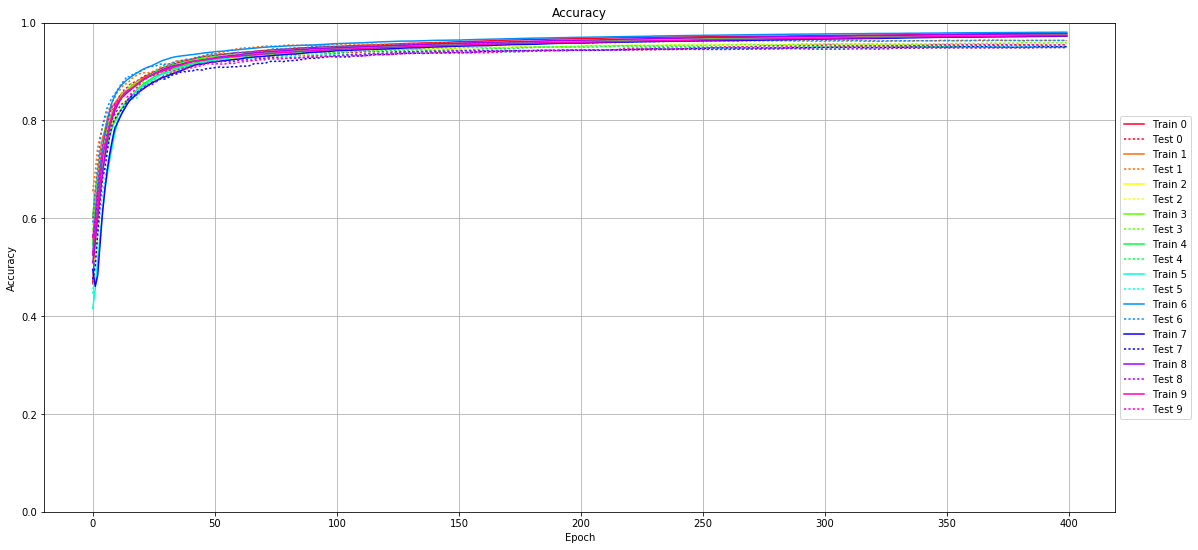

In [16]:
plot_acc(history)

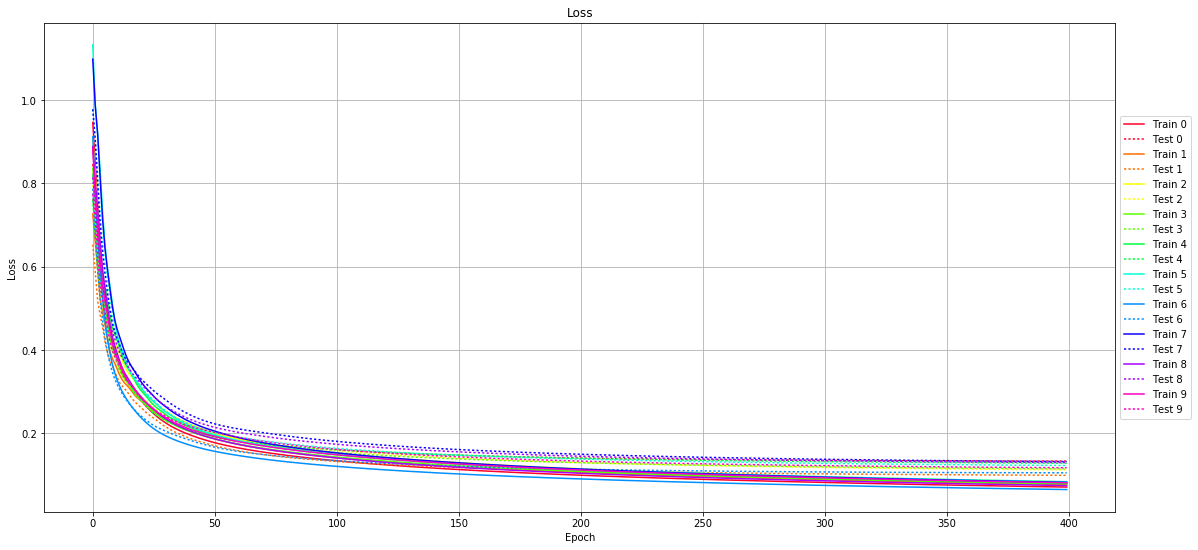

In [17]:
plot_loss(history)

In [18]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


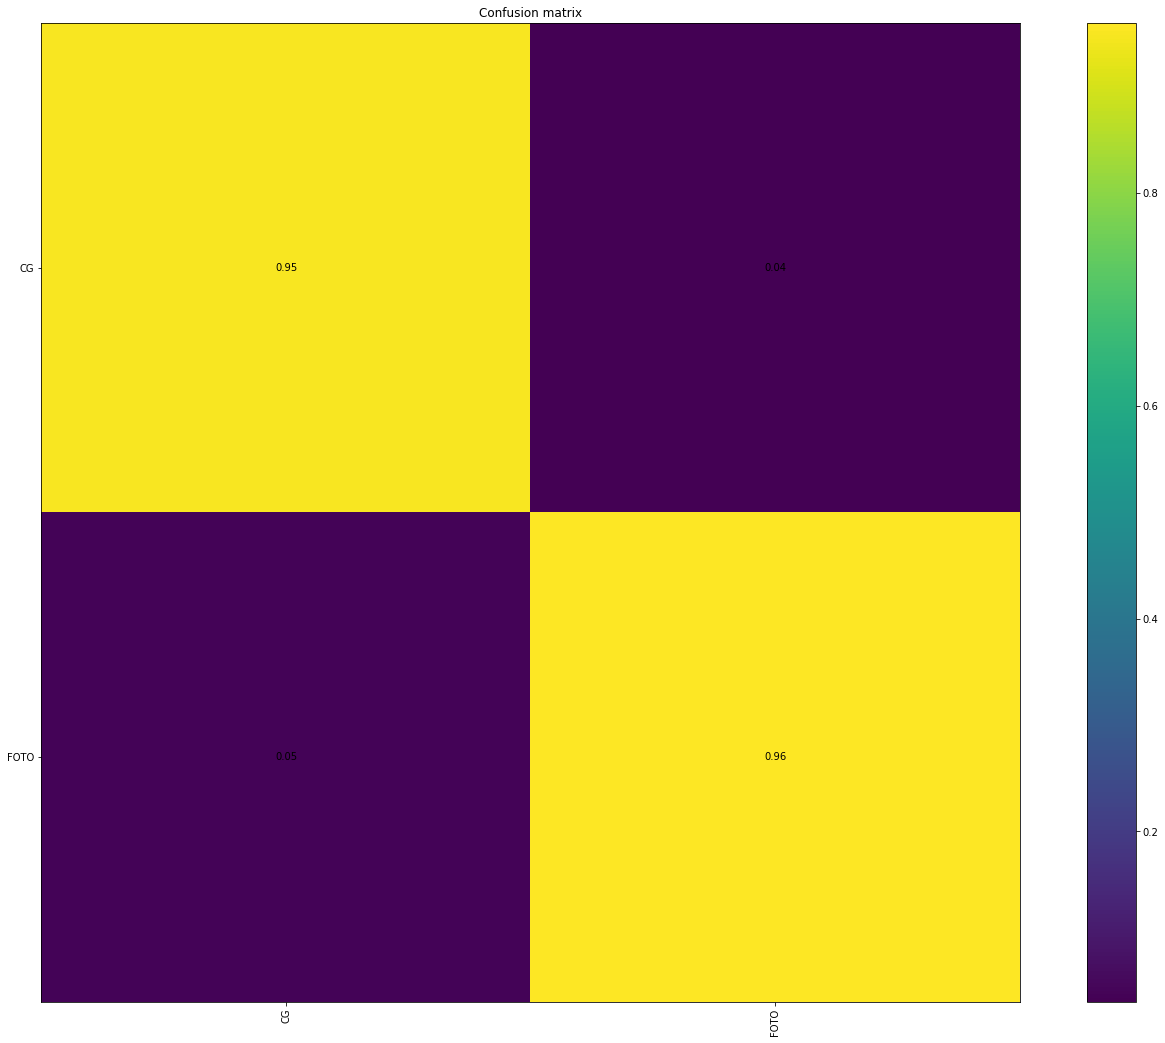

In [19]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()